<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB5] - Sentiment analysis with a LSTM network
<!-- DESC --> Still the same problem, but with a network combining embedding and LSTM
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Use of a model combining embedding and LSTM

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a Embedding/LSTM model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('IMDB3')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : IMDB3
Run time             : Monday 01 March 2021, 20:21:35
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

**Load dataset :**

In [2]:
vocab_size = 10000

# ----- Retrieve x,y

# Uncomment this if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

# To load a h5 version of the dataset :
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


**About this dataset :**

In [3]:
print("  Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


<br>**After translation :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint


### 2.4 - Have a look for NN

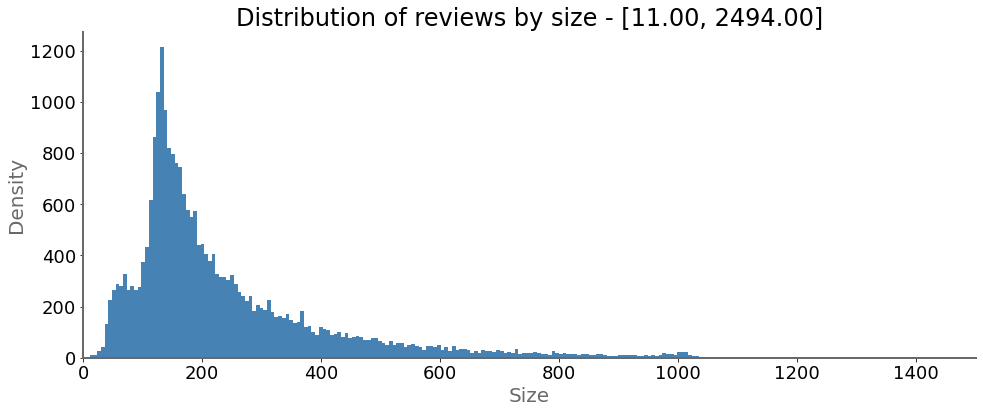

In [6]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])
pwk.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

**Save dataset and dictionary (For future use but not mandatory)**

In [8]:
# ---- Write dataset in a h5 file, could be usefull
#
output_dir = './data'
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it
GPU : batch_size=512 :  6' 30s  
CPU : batch_size=512 : 12' 57s

In [12]:
%%time

n_epochs   = 10
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/10


 1/49 [..............................] - ETA: 4:25 - loss: 0.6931 - accuracy: 0.5039

 2/49 [>.............................] - ETA: 29s - loss: 0.6931 - accuracy: 0.4971 

 3/49 [>.............................] - ETA: 28s - loss: 0.6932 - accuracy: 0.4924

 4/49 [=>............................] - ETA: 27s - loss: 0.6932 - accuracy: 0.4925

 5/49 [==>...........................] - ETA: 27s - loss: 0.6932 - accuracy: 0.4906

 6/49 [==>...........................] - ETA: 26s - loss: 0.6932 - accuracy: 0.4903

 7/49 [===>..........................] - ETA: 25s - loss: 0.6933 - accuracy: 0.4899

 8/49 [===>..........................] - ETA: 25s - loss: 0.6932 - accuracy: 0.4904

 9/49 [====>.........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.4911

10/49 [=====>........................] - ETA: 24s - loss: 0.6932 - accuracy: 0.4921

11/49 [=====>........................] - ETA: 23s - loss: 0.6932 - accuracy: 0.4927

12/49 [======>.......................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4936

13/49 [======>.......................] - ETA: 22s - loss: 0.6932 - accuracy: 0.4945

14/49 [=======>......................] - ETA: 21s - loss: 0.6932 - accuracy: 0.4953

15/49 [========>.....................] - ETA: 21s - loss: 0.6932 - accuracy: 0.4962

16/49 [========>.....................] - ETA: 20s - loss: 0.6932 - accuracy: 0.4971

17/49 [=========>....................] - ETA: 19s - loss: 0.6931 - accuracy: 0.4980

18/49 [==========>...................] - ETA: 19s - loss: 0.6931 - accuracy: 0.4989

19/49 [==========>...................] - ETA: 19s - loss: 0.6931 - accuracy: 0.4997

20/49 [===========>..................] - ETA: 18s - loss: 0.6931 - accuracy: 0.5006

21/49 [===========>..................] - ETA: 18s - loss: 0.6931 - accuracy: 0.5014

22/49 [============>.................] - ETA: 17s - loss: 0.6931 - accuracy: 0.5021

23/49 [=============>................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5028

24/49 [=============>................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5034

25/49 [==============>...............] - ETA: 15s - loss: 0.6930 - accuracy: 0.5039

26/49 [==============>...............] - ETA: 15s - loss: 0.6930 - accuracy: 0.5044

27/49 [===============>..............] - ETA: 14s - loss: 0.6930 - accuracy: 0.5049

28/49 [================>.............] - ETA: 13s - loss: 0.6930 - accuracy: 0.5053

29/49 [================>.............] - ETA: 13s - loss: 0.6930 - accuracy: 0.5056

30/49 [=================>............] - ETA: 12s - loss: 0.6930 - accuracy: 0.5060

31/49 [=================>............] - ETA: 11s - loss: 0.6930 - accuracy: 0.5063

32/49 [==================>...........] - ETA: 11s - loss: 0.6930 - accuracy: 0.5066

33/49 [===================>..........] - ETA: 10s - loss: 0.6930 - accuracy: 0.5069

34/49 [===================>..........] - ETA: 9s - loss: 0.6930 - accuracy: 0.5071 

35/49 [====================>.........] - ETA: 9s - loss: 0.6929 - accuracy: 0.5074

36/49 [=====================>........] - ETA: 8s - loss: 0.6929 - accuracy: 0.5077

37/49 [=====================>........] - ETA: 7s - loss: 0.6929 - accuracy: 0.5079

38/49 [======================>.......] - ETA: 7s - loss: 0.6929 - accuracy: 0.5081

39/49 [======================>.......] - ETA: 6s - loss: 0.6929 - accuracy: 0.5083

40/49 [=======================>......] - ETA: 5s - loss: 0.6929 - accuracy: 0.5085

41/49 [========================>.....] - ETA: 5s - loss: 0.6928 - accuracy: 0.5087

42/49 [========================>.....] - ETA: 4s - loss: 0.6928 - accuracy: 0.5088

43/49 [=========================>....] - ETA: 3s - loss: 0.6928 - accuracy: 0.5091

44/49 [=========================>....] - ETA: 3s - loss: 0.6928 - accuracy: 0.5093

45/49 [==========================>...] - ETA: 2s - loss: 0.6927 - accuracy: 0.5095

46/49 [===========================>..] - ETA: 2s - loss: 0.6927 - accuracy: 0.5097

47/49 [===========================>..] - ETA: 1s - loss: 0.6927 - accuracy: 0.5100

48/49 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5102

49/49 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5104

49/49 [==============================] - 43s 777ms/step - loss: 0.6926 - accuracy: 0.5107 - val_loss: 0.6881 - val_accuracy: 0.5604


Epoch 2/10


 1/49 [..............................] - ETA: 29s - loss: 0.6874 - accuracy: 0.5508

 2/49 [>.............................] - ETA: 29s - loss: 0.6871 - accuracy: 0.5527

 3/49 [>.............................] - ETA: 28s - loss: 0.6871 - accuracy: 0.5534

 4/49 [=>............................] - ETA: 27s - loss: 0.6872 - accuracy: 0.5529

 5/49 [==>...........................] - ETA: 27s - loss: 0.6872 - accuracy: 0.5513

 6/49 [==>...........................] - ETA: 26s - loss: 0.6872 - accuracy: 0.5503

 7/49 [===>..........................] - ETA: 25s - loss: 0.6872 - accuracy: 0.5502

 8/49 [===>..........................] - ETA: 25s - loss: 0.6871 - accuracy: 0.5506

 9/49 [====>.........................] - ETA: 24s - loss: 0.6870 - accuracy: 0.5514

10/49 [=====>........................] - ETA: 24s - loss: 0.6869 - accuracy: 0.5521

11/49 [=====>........................] - ETA: 24s - loss: 0.6868 - accuracy: 0.5529

12/49 [======>.......................] - ETA: 24s - loss: 0.6867 - accuracy: 0.5535

13/49 [======>.......................] - ETA: 24s - loss: 0.6865 - accuracy: 0.5540

14/49 [=======>......................] - ETA: 23s - loss: 0.6864 - accuracy: 0.5546

15/49 [========>.....................] - ETA: 23s - loss: 0.6864 - accuracy: 0.5548

16/49 [========>.....................] - ETA: 22s - loss: 0.6863 - accuracy: 0.5551

17/49 [=========>....................] - ETA: 21s - loss: 0.6862 - accuracy: 0.5553

18/49 [==========>...................] - ETA: 20s - loss: 0.6861 - accuracy: 0.5555

19/49 [==========>...................] - ETA: 20s - loss: 0.6860 - accuracy: 0.5558

20/49 [===========>..................] - ETA: 19s - loss: 0.6859 - accuracy: 0.5560

21/49 [===========>..................] - ETA: 18s - loss: 0.6858 - accuracy: 0.5561

22/49 [============>.................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5564

23/49 [=============>................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5569

24/49 [=============>................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5575

25/49 [==============>...............] - ETA: 15s - loss: 0.6851 - accuracy: 0.5583

26/49 [==============>...............] - ETA: 15s - loss: 0.6848 - accuracy: 0.5592

27/49 [===============>..............] - ETA: 14s - loss: 0.6844 - accuracy: 0.5600

28/49 [================>.............] - ETA: 13s - loss: 0.6840 - accuracy: 0.5610

29/49 [================>.............] - ETA: 13s - loss: 0.6834 - accuracy: 0.5621

30/49 [=================>............] - ETA: 12s - loss: 0.6828 - accuracy: 0.5634

31/49 [=================>............] - ETA: 11s - loss: 0.6820 - accuracy: 0.5646

32/49 [==================>...........] - ETA: 11s - loss: 0.6813 - accuracy: 0.5660

33/49 [===================>..........] - ETA: 10s - loss: 0.6805 - accuracy: 0.5674

34/49 [===================>..........] - ETA: 9s - loss: 0.6796 - accuracy: 0.5688 

35/49 [====================>.........] - ETA: 9s - loss: 0.6787 - accuracy: 0.5703

36/49 [=====================>........] - ETA: 8s - loss: 0.6777 - accuracy: 0.5718

37/49 [=====================>........] - ETA: 7s - loss: 0.6767 - accuracy: 0.5733

38/49 [======================>.......] - ETA: 7s - loss: 0.6756 - accuracy: 0.5749

39/49 [======================>.......] - ETA: 6s - loss: 0.6746 - accuracy: 0.5764

40/49 [=======================>......] - ETA: 5s - loss: 0.6735 - accuracy: 0.5779

41/49 [========================>.....] - ETA: 5s - loss: 0.6725 - accuracy: 0.5795

42/49 [========================>.....] - ETA: 4s - loss: 0.6713 - accuracy: 0.5811

43/49 [=========================>....] - ETA: 3s - loss: 0.6702 - accuracy: 0.5826

44/49 [=========================>....] - ETA: 3s - loss: 0.6691 - accuracy: 0.5842

45/49 [==========================>...] - ETA: 2s - loss: 0.6680 - accuracy: 0.5859

46/49 [===========================>..] - ETA: 1s - loss: 0.6668 - accuracy: 0.5875

47/49 [===========================>..] - ETA: 1s - loss: 0.6656 - accuracy: 0.5891

48/49 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.5906

49/49 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.5922

49/49 [==============================] - 35s 724ms/step - loss: 0.6623 - accuracy: 0.5936 - val_loss: 0.5006 - val_accuracy: 0.7664


Epoch 3/10


 1/49 [..............................] - ETA: 29s - loss: 0.4821 - accuracy: 0.7852

 2/49 [>.............................] - ETA: 28s - loss: 0.4791 - accuracy: 0.7856

 3/49 [>.............................] - ETA: 28s - loss: 0.4701 - accuracy: 0.7939

 4/49 [=>............................] - ETA: 27s - loss: 0.4630 - accuracy: 0.8005

 5/49 [==>...........................] - ETA: 29s - loss: 0.4595 - accuracy: 0.8052

 6/49 [==>...........................] - ETA: 28s - loss: 0.4572 - accuracy: 0.8083

 7/49 [===>..........................] - ETA: 27s - loss: 0.4546 - accuracy: 0.8110

 8/49 [===>..........................] - ETA: 27s - loss: 0.4515 - accuracy: 0.8139

 9/49 [====>.........................] - ETA: 27s - loss: 0.4487 - accuracy: 0.8166

10/49 [=====>........................] - ETA: 26s - loss: 0.4456 - accuracy: 0.8194

11/49 [=====>........................] - ETA: 25s - loss: 0.4430 - accuracy: 0.8218

12/49 [======>.......................] - ETA: 24s - loss: 0.4406 - accuracy: 0.8238

13/49 [======>.......................] - ETA: 23s - loss: 0.4383 - accuracy: 0.8257

14/49 [=======>......................] - ETA: 23s - loss: 0.4363 - accuracy: 0.8272

15/49 [========>.....................] - ETA: 22s - loss: 0.4346 - accuracy: 0.8285

16/49 [========>.....................] - ETA: 21s - loss: 0.4329 - accuracy: 0.8296

17/49 [=========>....................] - ETA: 20s - loss: 0.4313 - accuracy: 0.8308

18/49 [==========>...................] - ETA: 20s - loss: 0.4298 - accuracy: 0.8318

19/49 [==========>...................] - ETA: 19s - loss: 0.4284 - accuracy: 0.8327

20/49 [===========>..................] - ETA: 19s - loss: 0.4271 - accuracy: 0.8336

21/49 [===========>..................] - ETA: 18s - loss: 0.4258 - accuracy: 0.8345

22/49 [============>.................] - ETA: 17s - loss: 0.4246 - accuracy: 0.8352

23/49 [=============>................] - ETA: 17s - loss: 0.4235 - accuracy: 0.8360

24/49 [=============>................] - ETA: 16s - loss: 0.4222 - accuracy: 0.8367

25/49 [==============>...............] - ETA: 16s - loss: 0.4210 - accuracy: 0.8375

26/49 [==============>...............] - ETA: 15s - loss: 0.4198 - accuracy: 0.8382

27/49 [===============>..............] - ETA: 14s - loss: 0.4187 - accuracy: 0.8388

28/49 [================>.............] - ETA: 14s - loss: 0.4177 - accuracy: 0.8394

29/49 [================>.............] - ETA: 13s - loss: 0.4166 - accuracy: 0.8401

30/49 [=================>............] - ETA: 12s - loss: 0.4155 - accuracy: 0.8407

31/49 [=================>............] - ETA: 12s - loss: 0.4145 - accuracy: 0.8412

32/49 [==================>...........] - ETA: 11s - loss: 0.4135 - accuracy: 0.8418

33/49 [===================>..........] - ETA: 10s - loss: 0.4125 - accuracy: 0.8424

34/49 [===================>..........] - ETA: 9s - loss: 0.4116 - accuracy: 0.8428 

35/49 [====================>.........] - ETA: 9s - loss: 0.4106 - accuracy: 0.8433

36/49 [=====================>........] - ETA: 8s - loss: 0.4097 - accuracy: 0.8438

37/49 [=====================>........] - ETA: 7s - loss: 0.4089 - accuracy: 0.8442

38/49 [======================>.......] - ETA: 7s - loss: 0.4081 - accuracy: 0.8446

39/49 [======================>.......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8450

40/49 [=======================>......] - ETA: 5s - loss: 0.4069 - accuracy: 0.8453

41/49 [========================>.....] - ETA: 5s - loss: 0.4063 - accuracy: 0.8457

42/49 [========================>.....] - ETA: 4s - loss: 0.4057 - accuracy: 0.8460

43/49 [=========================>....] - ETA: 3s - loss: 0.4051 - accuracy: 0.8464

44/49 [=========================>....] - ETA: 3s - loss: 0.4046 - accuracy: 0.8467

45/49 [==========================>...] - ETA: 2s - loss: 0.4040 - accuracy: 0.8470

46/49 [===========================>..] - ETA: 1s - loss: 0.4035 - accuracy: 0.8473

47/49 [===========================>..] - ETA: 1s - loss: 0.4029 - accuracy: 0.8476

48/49 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.8479

49/49 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8482

49/49 [==============================] - 36s 733ms/step - loss: 0.4014 - accuracy: 0.8484 - val_loss: 0.3748 - val_accuracy: 0.8512


Epoch 4/10


 1/49 [..............................] - ETA: 29s - loss: 0.3360 - accuracy: 0.8848

 2/49 [>.............................] - ETA: 32s - loss: 0.3357 - accuracy: 0.8882

 3/49 [>.............................] - ETA: 30s - loss: 0.3272 - accuracy: 0.8927

 4/49 [=>............................] - ETA: 28s - loss: 0.3239 - accuracy: 0.8942

 5/49 [==>...........................] - ETA: 28s - loss: 0.3217 - accuracy: 0.8951

 6/49 [==>...........................] - ETA: 27s - loss: 0.3217 - accuracy: 0.8952

 7/49 [===>..........................] - ETA: 26s - loss: 0.3225 - accuracy: 0.8947

 8/49 [===>..........................] - ETA: 25s - loss: 0.3241 - accuracy: 0.8940

 9/49 [====>.........................] - ETA: 25s - loss: 0.3251 - accuracy: 0.8935

10/49 [=====>........................] - ETA: 24s - loss: 0.3261 - accuracy: 0.8929

11/49 [=====>........................] - ETA: 23s - loss: 0.3269 - accuracy: 0.8925

12/49 [======>.......................] - ETA: 23s - loss: 0.3279 - accuracy: 0.8923

13/49 [======>.......................] - ETA: 22s - loss: 0.3287 - accuracy: 0.8921

14/49 [=======>......................] - ETA: 21s - loss: 0.3294 - accuracy: 0.8919

15/49 [========>.....................] - ETA: 21s - loss: 0.3298 - accuracy: 0.8918

16/49 [========>.....................] - ETA: 20s - loss: 0.3301 - accuracy: 0.8918

17/49 [=========>....................] - ETA: 20s - loss: 0.3304 - accuracy: 0.8918

18/49 [==========>...................] - ETA: 19s - loss: 0.3311 - accuracy: 0.8916

19/49 [==========>...................] - ETA: 18s - loss: 0.3318 - accuracy: 0.8915

20/49 [===========>..................] - ETA: 18s - loss: 0.3323 - accuracy: 0.8913

21/49 [===========>..................] - ETA: 17s - loss: 0.3328 - accuracy: 0.8911

22/49 [============>.................] - ETA: 16s - loss: 0.3333 - accuracy: 0.8909

23/49 [=============>................] - ETA: 16s - loss: 0.3338 - accuracy: 0.8907

24/49 [=============>................] - ETA: 15s - loss: 0.3343 - accuracy: 0.8906

25/49 [==============>...............] - ETA: 14s - loss: 0.3347 - accuracy: 0.8904

26/49 [==============>...............] - ETA: 14s - loss: 0.3350 - accuracy: 0.8903

27/49 [===============>..............] - ETA: 13s - loss: 0.3352 - accuracy: 0.8902

28/49 [================>.............] - ETA: 13s - loss: 0.3353 - accuracy: 0.8901

29/49 [================>.............] - ETA: 12s - loss: 0.3354 - accuracy: 0.8900

30/49 [=================>............] - ETA: 11s - loss: 0.3355 - accuracy: 0.8899

31/49 [=================>............] - ETA: 11s - loss: 0.3355 - accuracy: 0.8899

32/49 [==================>...........] - ETA: 10s - loss: 0.3355 - accuracy: 0.8899

33/49 [===================>..........] - ETA: 9s - loss: 0.3354 - accuracy: 0.8899 

34/49 [===================>..........] - ETA: 9s - loss: 0.3354 - accuracy: 0.8899

35/49 [====================>.........] - ETA: 8s - loss: 0.3352 - accuracy: 0.8899

36/49 [=====================>........] - ETA: 8s - loss: 0.3351 - accuracy: 0.8899

37/49 [=====================>........] - ETA: 7s - loss: 0.3349 - accuracy: 0.8900

38/49 [======================>.......] - ETA: 6s - loss: 0.3348 - accuracy: 0.8900

39/49 [======================>.......] - ETA: 6s - loss: 0.3346 - accuracy: 0.8900

40/49 [=======================>......] - ETA: 5s - loss: 0.3344 - accuracy: 0.8901

41/49 [========================>.....] - ETA: 4s - loss: 0.3342 - accuracy: 0.8901

42/49 [========================>.....] - ETA: 4s - loss: 0.3340 - accuracy: 0.8902

43/49 [=========================>....] - ETA: 3s - loss: 0.3338 - accuracy: 0.8902

44/49 [=========================>....] - ETA: 3s - loss: 0.3336 - accuracy: 0.8903

45/49 [==========================>...] - ETA: 2s - loss: 0.3333 - accuracy: 0.8903

46/49 [===========================>..] - ETA: 1s - loss: 0.3331 - accuracy: 0.8904

47/49 [===========================>..] - ETA: 1s - loss: 0.3328 - accuracy: 0.8904

48/49 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8905

49/49 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.8905

49/49 [==============================] - 34s 701ms/step - loss: 0.3321 - accuracy: 0.8905 - val_loss: 0.3588 - val_accuracy: 0.8655


Epoch 5/10


 1/49 [..............................] - ETA: 29s - loss: 0.2722 - accuracy: 0.9062

 2/49 [>.............................] - ETA: 29s - loss: 0.2820 - accuracy: 0.9043

 3/49 [>.............................] - ETA: 28s - loss: 0.2861 - accuracy: 0.9041

 4/49 [=>............................] - ETA: 27s - loss: 0.2858 - accuracy: 0.9045

 5/49 [==>...........................] - ETA: 27s - loss: 0.2831 - accuracy: 0.9060

 6/49 [==>...........................] - ETA: 26s - loss: 0.2809 - accuracy: 0.9071

 7/49 [===>..........................] - ETA: 26s - loss: 0.2798 - accuracy: 0.9078

 8/49 [===>..........................] - ETA: 25s - loss: 0.2784 - accuracy: 0.9084

 9/49 [====>.........................] - ETA: 24s - loss: 0.2772 - accuracy: 0.9089

10/49 [=====>........................] - ETA: 24s - loss: 0.2762 - accuracy: 0.9092

11/49 [=====>........................] - ETA: 23s - loss: 0.2756 - accuracy: 0.9095

12/49 [======>.......................] - ETA: 22s - loss: 0.2750 - accuracy: 0.9098

13/49 [======>.......................] - ETA: 22s - loss: 0.2748 - accuracy: 0.9099

14/49 [=======>......................] - ETA: 21s - loss: 0.2746 - accuracy: 0.9100

15/49 [========>.....................] - ETA: 21s - loss: 0.2748 - accuracy: 0.9100

16/49 [========>.....................] - ETA: 20s - loss: 0.2755 - accuracy: 0.9098

17/49 [=========>....................] - ETA: 19s - loss: 0.2765 - accuracy: 0.9095

18/49 [==========>...................] - ETA: 19s - loss: 0.2775 - accuracy: 0.9093

19/49 [==========>...................] - ETA: 18s - loss: 0.2783 - accuracy: 0.9090

20/49 [===========>..................] - ETA: 17s - loss: 0.2790 - accuracy: 0.9089

21/49 [===========>..................] - ETA: 17s - loss: 0.2797 - accuracy: 0.9087

22/49 [============>.................] - ETA: 16s - loss: 0.2804 - accuracy: 0.9084

23/49 [=============>................] - ETA: 16s - loss: 0.2811 - accuracy: 0.9082

24/49 [=============>................] - ETA: 15s - loss: 0.2819 - accuracy: 0.9079

25/49 [==============>...............] - ETA: 14s - loss: 0.2827 - accuracy: 0.9075

26/49 [==============>...............] - ETA: 14s - loss: 0.2834 - accuracy: 0.9072

27/49 [===============>..............] - ETA: 13s - loss: 0.2841 - accuracy: 0.9069

28/49 [================>.............] - ETA: 13s - loss: 0.2847 - accuracy: 0.9066

29/49 [================>.............] - ETA: 12s - loss: 0.2853 - accuracy: 0.9063

30/49 [=================>............] - ETA: 11s - loss: 0.2859 - accuracy: 0.9061

31/49 [=================>............] - ETA: 11s - loss: 0.2864 - accuracy: 0.9058

32/49 [==================>...........] - ETA: 10s - loss: 0.2869 - accuracy: 0.9056

33/49 [===================>..........] - ETA: 9s - loss: 0.2875 - accuracy: 0.9053 

34/49 [===================>..........] - ETA: 9s - loss: 0.2880 - accuracy: 0.9051

35/49 [====================>.........] - ETA: 8s - loss: 0.2884 - accuracy: 0.9049

36/49 [=====================>........] - ETA: 8s - loss: 0.2888 - accuracy: 0.9047

37/49 [=====================>........] - ETA: 7s - loss: 0.2891 - accuracy: 0.9045

38/49 [======================>.......] - ETA: 7s - loss: 0.2894 - accuracy: 0.9044

39/49 [======================>.......] - ETA: 6s - loss: 0.2897 - accuracy: 0.9042

40/49 [=======================>......] - ETA: 5s - loss: 0.2900 - accuracy: 0.9041

41/49 [========================>.....] - ETA: 5s - loss: 0.2902 - accuracy: 0.9040

42/49 [========================>.....] - ETA: 4s - loss: 0.2904 - accuracy: 0.9039

43/49 [=========================>....] - ETA: 3s - loss: 0.2906 - accuracy: 0.9038

44/49 [=========================>....] - ETA: 3s - loss: 0.2908 - accuracy: 0.9037

45/49 [==========================>...] - ETA: 2s - loss: 0.2910 - accuracy: 0.9036

46/49 [===========================>..] - ETA: 1s - loss: 0.2912 - accuracy: 0.9035

47/49 [===========================>..] - ETA: 1s - loss: 0.2913 - accuracy: 0.9034

48/49 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.9034

49/49 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.9033

49/49 [==============================] - 36s 732ms/step - loss: 0.2917 - accuracy: 0.9033 - val_loss: 0.3586 - val_accuracy: 0.8687


Epoch 6/10


 1/49 [..............................] - ETA: 29s - loss: 0.2213 - accuracy: 0.9355

 2/49 [>.............................] - ETA: 28s - loss: 0.2309 - accuracy: 0.9307

 3/49 [>.............................] - ETA: 30s - loss: 0.2374 - accuracy: 0.9275

 4/49 [=>............................] - ETA: 32s - loss: 0.2454 - accuracy: 0.9240

 5/49 [==>...........................] - ETA: 32s - loss: 0.2513 - accuracy: 0.9215

 6/49 [==>...........................] - ETA: 31s - loss: 0.2550 - accuracy: 0.9199

 7/49 [===>..........................] - ETA: 29s - loss: 0.2569 - accuracy: 0.9192

 8/49 [===>..........................] - ETA: 28s - loss: 0.2589 - accuracy: 0.9183

 9/49 [====>.........................] - ETA: 27s - loss: 0.2602 - accuracy: 0.9178

10/49 [=====>........................] - ETA: 27s - loss: 0.2614 - accuracy: 0.9175

11/49 [=====>........................] - ETA: 27s - loss: 0.2623 - accuracy: 0.9171

12/49 [======>.......................] - ETA: 27s - loss: 0.2630 - accuracy: 0.9168

13/49 [======>.......................] - ETA: 26s - loss: 0.2635 - accuracy: 0.9167

14/49 [=======>......................] - ETA: 25s - loss: 0.2637 - accuracy: 0.9166

15/49 [========>.....................] - ETA: 25s - loss: 0.2638 - accuracy: 0.9166

16/49 [========>.....................] - ETA: 24s - loss: 0.2638 - accuracy: 0.9166

17/49 [=========>....................] - ETA: 23s - loss: 0.2637 - accuracy: 0.9167

18/49 [==========>...................] - ETA: 23s - loss: 0.2636 - accuracy: 0.9167

19/49 [==========>...................] - ETA: 22s - loss: 0.2634 - accuracy: 0.9168

20/49 [===========>..................] - ETA: 22s - loss: 0.2634 - accuracy: 0.9168

21/49 [===========>..................] - ETA: 21s - loss: 0.2634 - accuracy: 0.9168

22/49 [============>.................] - ETA: 20s - loss: 0.2633 - accuracy: 0.9169

23/49 [=============>................] - ETA: 19s - loss: 0.2633 - accuracy: 0.9168

24/49 [=============>................] - ETA: 18s - loss: 0.2633 - accuracy: 0.9168

25/49 [==============>...............] - ETA: 17s - loss: 0.2633 - accuracy: 0.9168

26/49 [==============>...............] - ETA: 16s - loss: 0.2633 - accuracy: 0.9168

27/49 [===============>..............] - ETA: 16s - loss: 0.2633 - accuracy: 0.9168

28/49 [================>.............] - ETA: 15s - loss: 0.2633 - accuracy: 0.9168

29/49 [================>.............] - ETA: 14s - loss: 0.2633 - accuracy: 0.9168

30/49 [=================>............] - ETA: 13s - loss: 0.2632 - accuracy: 0.9168

31/49 [=================>............] - ETA: 12s - loss: 0.2630 - accuracy: 0.9169

32/49 [==================>...........] - ETA: 12s - loss: 0.2629 - accuracy: 0.9169

33/49 [===================>..........] - ETA: 11s - loss: 0.2627 - accuracy: 0.9170

34/49 [===================>..........] - ETA: 10s - loss: 0.2625 - accuracy: 0.9170

35/49 [====================>.........] - ETA: 10s - loss: 0.2623 - accuracy: 0.9171

36/49 [=====================>........] - ETA: 9s - loss: 0.2621 - accuracy: 0.9172 

37/49 [=====================>........] - ETA: 8s - loss: 0.2619 - accuracy: 0.9172

38/49 [======================>.......] - ETA: 7s - loss: 0.2617 - accuracy: 0.9173

39/49 [======================>.......] - ETA: 7s - loss: 0.2615 - accuracy: 0.9173

40/49 [=======================>......] - ETA: 6s - loss: 0.2614 - accuracy: 0.9174

41/49 [========================>.....] - ETA: 5s - loss: 0.2612 - accuracy: 0.9174

42/49 [========================>.....] - ETA: 4s - loss: 0.2610 - accuracy: 0.9175

43/49 [=========================>....] - ETA: 4s - loss: 0.2609 - accuracy: 0.9175

44/49 [=========================>....] - ETA: 3s - loss: 0.2607 - accuracy: 0.9176

45/49 [==========================>...] - ETA: 2s - loss: 0.2605 - accuracy: 0.9177

46/49 [===========================>..] - ETA: 2s - loss: 0.2603 - accuracy: 0.9177

47/49 [===========================>..] - ETA: 1s - loss: 0.2601 - accuracy: 0.9178

48/49 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9179

49/49 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9179

49/49 [==============================] - 37s 761ms/step - loss: 0.2595 - accuracy: 0.9180 - val_loss: 0.3350 - val_accuracy: 0.8731


Epoch 7/10


 1/49 [..............................] - ETA: 29s - loss: 0.2400 - accuracy: 0.9297

 2/49 [>.............................] - ETA: 29s - loss: 0.2386 - accuracy: 0.9297

 3/49 [>.............................] - ETA: 28s - loss: 0.2357 - accuracy: 0.9310

 4/49 [=>............................] - ETA: 27s - loss: 0.2342 - accuracy: 0.9314

 5/49 [==>...........................] - ETA: 27s - loss: 0.2316 - accuracy: 0.9323

 6/49 [==>...........................] - ETA: 26s - loss: 0.2298 - accuracy: 0.9328

 7/49 [===>..........................] - ETA: 25s - loss: 0.2286 - accuracy: 0.9331

 8/49 [===>..........................] - ETA: 25s - loss: 0.2288 - accuracy: 0.9331

 9/49 [====>.........................] - ETA: 24s - loss: 0.2291 - accuracy: 0.9330

10/49 [=====>........................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9329

11/49 [=====>........................] - ETA: 23s - loss: 0.2297 - accuracy: 0.9328

12/49 [======>.......................] - ETA: 22s - loss: 0.2297 - accuracy: 0.9329

13/49 [======>.......................] - ETA: 22s - loss: 0.2294 - accuracy: 0.9330

14/49 [=======>......................] - ETA: 21s - loss: 0.2292 - accuracy: 0.9330

15/49 [========>.....................] - ETA: 20s - loss: 0.2289 - accuracy: 0.9331

16/49 [========>.....................] - ETA: 20s - loss: 0.2284 - accuracy: 0.9332

17/49 [=========>....................] - ETA: 19s - loss: 0.2278 - accuracy: 0.9333

18/49 [==========>...................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9334

19/49 [==========>...................] - ETA: 18s - loss: 0.2269 - accuracy: 0.9335

20/49 [===========>..................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9335

21/49 [===========>..................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9335

22/49 [============>.................] - ETA: 16s - loss: 0.2263 - accuracy: 0.9335

23/49 [=============>................] - ETA: 16s - loss: 0.2261 - accuracy: 0.9335

24/49 [=============>................] - ETA: 15s - loss: 0.2260 - accuracy: 0.9334

25/49 [==============>...............] - ETA: 14s - loss: 0.2258 - accuracy: 0.9335

26/49 [==============>...............] - ETA: 14s - loss: 0.2257 - accuracy: 0.9335

27/49 [===============>..............] - ETA: 13s - loss: 0.2255 - accuracy: 0.9335

28/49 [================>.............] - ETA: 12s - loss: 0.2254 - accuracy: 0.9335

29/49 [================>.............] - ETA: 12s - loss: 0.2253 - accuracy: 0.9335

30/49 [=================>............] - ETA: 11s - loss: 0.2252 - accuracy: 0.9335

31/49 [=================>............] - ETA: 11s - loss: 0.2250 - accuracy: 0.9335

32/49 [==================>...........] - ETA: 10s - loss: 0.2249 - accuracy: 0.9335

33/49 [===================>..........] - ETA: 10s - loss: 0.2247 - accuracy: 0.9335

34/49 [===================>..........] - ETA: 9s - loss: 0.2246 - accuracy: 0.9335 

35/49 [====================>.........] - ETA: 8s - loss: 0.2245 - accuracy: 0.9335

36/49 [=====================>........] - ETA: 8s - loss: 0.2244 - accuracy: 0.9335

37/49 [=====================>........] - ETA: 7s - loss: 0.2243 - accuracy: 0.9335

38/49 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9335

39/49 [======================>.......] - ETA: 6s - loss: 0.2241 - accuracy: 0.9335

40/49 [=======================>......] - ETA: 5s - loss: 0.2240 - accuracy: 0.9335

41/49 [========================>.....] - ETA: 5s - loss: 0.2240 - accuracy: 0.9334

42/49 [========================>.....] - ETA: 4s - loss: 0.2239 - accuracy: 0.9334

43/49 [=========================>....] - ETA: 3s - loss: 0.2238 - accuracy: 0.9334

44/49 [=========================>....] - ETA: 3s - loss: 0.2238 - accuracy: 0.9334

45/49 [==========================>...] - ETA: 2s - loss: 0.2237 - accuracy: 0.9333

46/49 [===========================>..] - ETA: 1s - loss: 0.2236 - accuracy: 0.9333

47/49 [===========================>..] - ETA: 1s - loss: 0.2235 - accuracy: 0.9333

48/49 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9333

49/49 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9333

49/49 [==============================] - 36s 736ms/step - loss: 0.2233 - accuracy: 0.9333 - val_loss: 0.3772 - val_accuracy: 0.8661


Epoch 8/10


 1/49 [..............................] - ETA: 29s - loss: 0.2074 - accuracy: 0.9375

 2/49 [>.............................] - ETA: 30s - loss: 0.2011 - accuracy: 0.9395

 3/49 [>.............................] - ETA: 29s - loss: 0.1989 - accuracy: 0.9408

 4/49 [=>............................] - ETA: 29s - loss: 0.1970 - accuracy: 0.9417

 5/49 [==>...........................] - ETA: 28s - loss: 0.1973 - accuracy: 0.9416

 6/49 [==>...........................] - ETA: 27s - loss: 0.1971 - accuracy: 0.9417

 7/49 [===>..........................] - ETA: 27s - loss: 0.1972 - accuracy: 0.9417

 8/49 [===>..........................] - ETA: 26s - loss: 0.1973 - accuracy: 0.9415

 9/49 [====>.........................] - ETA: 25s - loss: 0.1972 - accuracy: 0.9414

10/49 [=====>........................] - ETA: 24s - loss: 0.1970 - accuracy: 0.9413

11/49 [=====>........................] - ETA: 24s - loss: 0.1969 - accuracy: 0.9412

12/49 [======>.......................] - ETA: 24s - loss: 0.1967 - accuracy: 0.9412

13/49 [======>.......................] - ETA: 24s - loss: 0.1964 - accuracy: 0.9413

14/49 [=======>......................] - ETA: 23s - loss: 0.1964 - accuracy: 0.9412

15/49 [========>.....................] - ETA: 23s - loss: 0.1964 - accuracy: 0.9412

16/49 [========>.....................] - ETA: 22s - loss: 0.1962 - accuracy: 0.9412

17/49 [=========>....................] - ETA: 21s - loss: 0.1960 - accuracy: 0.9412

18/49 [==========>...................] - ETA: 21s - loss: 0.1959 - accuracy: 0.9413

19/49 [==========>...................] - ETA: 20s - loss: 0.1958 - accuracy: 0.9413

20/49 [===========>..................] - ETA: 19s - loss: 0.1957 - accuracy: 0.9413

21/49 [===========>..................] - ETA: 19s - loss: 0.1955 - accuracy: 0.9413

22/49 [============>.................] - ETA: 18s - loss: 0.1953 - accuracy: 0.9414

23/49 [=============>................] - ETA: 17s - loss: 0.1950 - accuracy: 0.9415

24/49 [=============>................] - ETA: 17s - loss: 0.1948 - accuracy: 0.9415

25/49 [==============>...............] - ETA: 16s - loss: 0.1946 - accuracy: 0.9416

26/49 [==============>...............] - ETA: 16s - loss: 0.1944 - accuracy: 0.9416

27/49 [===============>..............] - ETA: 15s - loss: 0.1942 - accuracy: 0.9416

28/49 [================>.............] - ETA: 14s - loss: 0.1940 - accuracy: 0.9417

29/49 [================>.............] - ETA: 13s - loss: 0.1938 - accuracy: 0.9417

30/49 [=================>............] - ETA: 13s - loss: 0.1936 - accuracy: 0.9418

31/49 [=================>............] - ETA: 12s - loss: 0.1935 - accuracy: 0.9418

32/49 [==================>...........] - ETA: 11s - loss: 0.1934 - accuracy: 0.9418

33/49 [===================>..........] - ETA: 11s - loss: 0.1932 - accuracy: 0.9418

34/49 [===================>..........] - ETA: 10s - loss: 0.1932 - accuracy: 0.9418

35/49 [====================>.........] - ETA: 9s - loss: 0.1931 - accuracy: 0.9418 

36/49 [=====================>........] - ETA: 9s - loss: 0.1931 - accuracy: 0.9417

37/49 [=====================>........] - ETA: 8s - loss: 0.1930 - accuracy: 0.9417

38/49 [======================>.......] - ETA: 7s - loss: 0.1930 - accuracy: 0.9417

39/49 [======================>.......] - ETA: 6s - loss: 0.1930 - accuracy: 0.9416

40/49 [=======================>......] - ETA: 6s - loss: 0.1930 - accuracy: 0.9416

41/49 [========================>.....] - ETA: 5s - loss: 0.1930 - accuracy: 0.9416

42/49 [========================>.....] - ETA: 4s - loss: 0.1930 - accuracy: 0.9415

43/49 [=========================>....] - ETA: 4s - loss: 0.1930 - accuracy: 0.9415

44/49 [=========================>....] - ETA: 3s - loss: 0.1931 - accuracy: 0.9414

45/49 [==========================>...] - ETA: 2s - loss: 0.1931 - accuracy: 0.9414

46/49 [===========================>..] - ETA: 2s - loss: 0.1931 - accuracy: 0.9413

47/49 [===========================>..] - ETA: 1s - loss: 0.1931 - accuracy: 0.9413

48/49 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9413

49/49 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9412

49/49 [==============================] - 37s 764ms/step - loss: 0.1932 - accuracy: 0.9412 - val_loss: 0.3347 - val_accuracy: 0.8728


Epoch 9/10


 1/49 [..............................] - ETA: 29s - loss: 0.1136 - accuracy: 0.9785

 2/49 [>.............................] - ETA: 28s - loss: 0.1255 - accuracy: 0.9697

 3/49 [>.............................] - ETA: 33s - loss: 0.1333 - accuracy: 0.9661

 4/49 [=>............................] - ETA: 33s - loss: 0.1384 - accuracy: 0.9639

 5/49 [==>...........................] - ETA: 34s - loss: 0.1405 - accuracy: 0.9628

 6/49 [==>...........................] - ETA: 32s - loss: 0.1416 - accuracy: 0.9622

 7/49 [===>..........................] - ETA: 32s - loss: 0.1424 - accuracy: 0.9616

 8/49 [===>..........................] - ETA: 32s - loss: 0.1441 - accuracy: 0.9608

 9/49 [====>.........................] - ETA: 31s - loss: 0.1454 - accuracy: 0.9602

10/49 [=====>........................] - ETA: 30s - loss: 0.1466 - accuracy: 0.9597

11/49 [=====>........................] - ETA: 30s - loss: 0.1476 - accuracy: 0.9592

12/49 [======>.......................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9589

13/49 [======>.......................] - ETA: 28s - loss: 0.1496 - accuracy: 0.9585

14/49 [=======>......................] - ETA: 27s - loss: 0.1504 - accuracy: 0.9581

15/49 [========>.....................] - ETA: 25s - loss: 0.1511 - accuracy: 0.9578

16/49 [========>.....................] - ETA: 24s - loss: 0.1518 - accuracy: 0.9576

17/49 [=========>....................] - ETA: 24s - loss: 0.1523 - accuracy: 0.9573

18/49 [==========>...................] - ETA: 23s - loss: 0.1528 - accuracy: 0.9572

19/49 [==========>...................] - ETA: 23s - loss: 0.1532 - accuracy: 0.9570

20/49 [===========>..................] - ETA: 22s - loss: 0.1536 - accuracy: 0.9568

21/49 [===========>..................] - ETA: 21s - loss: 0.1540 - accuracy: 0.9566

22/49 [============>.................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9565

23/49 [=============>................] - ETA: 19s - loss: 0.1546 - accuracy: 0.9563

24/49 [=============>................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9562

25/49 [==============>...............] - ETA: 17s - loss: 0.1551 - accuracy: 0.9561

26/49 [==============>...............] - ETA: 16s - loss: 0.1555 - accuracy: 0.9559

27/49 [===============>..............] - ETA: 16s - loss: 0.1558 - accuracy: 0.9558

28/49 [================>.............] - ETA: 15s - loss: 0.1561 - accuracy: 0.9557

29/49 [================>.............] - ETA: 14s - loss: 0.1563 - accuracy: 0.9556

30/49 [=================>............] - ETA: 13s - loss: 0.1565 - accuracy: 0.9555

31/49 [=================>............] - ETA: 12s - loss: 0.1567 - accuracy: 0.9554

32/49 [==================>...........] - ETA: 12s - loss: 0.1570 - accuracy: 0.9553

33/49 [===================>..........] - ETA: 11s - loss: 0.1573 - accuracy: 0.9552

34/49 [===================>..........] - ETA: 10s - loss: 0.1576 - accuracy: 0.9551

35/49 [====================>.........] - ETA: 9s - loss: 0.1578 - accuracy: 0.9549 

36/49 [=====================>........] - ETA: 9s - loss: 0.1581 - accuracy: 0.9548

37/49 [=====================>........] - ETA: 8s - loss: 0.1584 - accuracy: 0.9547

38/49 [======================>.......] - ETA: 7s - loss: 0.1587 - accuracy: 0.9546

39/49 [======================>.......] - ETA: 7s - loss: 0.1590 - accuracy: 0.9545

40/49 [=======================>......] - ETA: 6s - loss: 0.1593 - accuracy: 0.9544

41/49 [========================>.....] - ETA: 5s - loss: 0.1596 - accuracy: 0.9543

42/49 [========================>.....] - ETA: 4s - loss: 0.1599 - accuracy: 0.9541

43/49 [=========================>....] - ETA: 4s - loss: 0.1602 - accuracy: 0.9540

44/49 [=========================>....] - ETA: 3s - loss: 0.1605 - accuracy: 0.9539

45/49 [==========================>...] - ETA: 2s - loss: 0.1608 - accuracy: 0.9538

46/49 [===========================>..] - ETA: 2s - loss: 0.1611 - accuracy: 0.9537

47/49 [===========================>..] - ETA: 1s - loss: 0.1614 - accuracy: 0.9535

48/49 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9534

49/49 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9533

49/49 [==============================] - 38s 786ms/step - loss: 0.1623 - accuracy: 0.9532 - val_loss: 0.3484 - val_accuracy: 0.8672


Epoch 10/10


 1/49 [..............................] - ETA: 29s - loss: 0.1917 - accuracy: 0.9434

 2/49 [>.............................] - ETA: 28s - loss: 0.1942 - accuracy: 0.9429

 3/49 [>.............................] - ETA: 28s - loss: 0.1950 - accuracy: 0.9424

 4/49 [=>............................] - ETA: 27s - loss: 0.1944 - accuracy: 0.9426

 5/49 [==>...........................] - ETA: 27s - loss: 0.1928 - accuracy: 0.9435

 6/49 [==>...........................] - ETA: 26s - loss: 0.1896 - accuracy: 0.9447

 7/49 [===>..........................] - ETA: 25s - loss: 0.1861 - accuracy: 0.9459

 8/49 [===>..........................] - ETA: 25s - loss: 0.1829 - accuracy: 0.9472

 9/49 [====>.........................] - ETA: 24s - loss: 0.1800 - accuracy: 0.9483

10/49 [=====>........................] - ETA: 24s - loss: 0.1776 - accuracy: 0.9491

11/49 [=====>........................] - ETA: 23s - loss: 0.1762 - accuracy: 0.9497

12/49 [======>.......................] - ETA: 22s - loss: 0.1749 - accuracy: 0.9501

13/49 [======>.......................] - ETA: 22s - loss: 0.1742 - accuracy: 0.9504

14/49 [=======>......................] - ETA: 21s - loss: 0.1732 - accuracy: 0.9507

15/49 [========>.....................] - ETA: 21s - loss: 0.1722 - accuracy: 0.9511

16/49 [========>.....................] - ETA: 20s - loss: 0.1712 - accuracy: 0.9514

17/49 [=========>....................] - ETA: 19s - loss: 0.1705 - accuracy: 0.9516

18/49 [==========>...................] - ETA: 19s - loss: 0.1699 - accuracy: 0.9518

19/49 [==========>...................] - ETA: 18s - loss: 0.1693 - accuracy: 0.9520

20/49 [===========>..................] - ETA: 17s - loss: 0.1688 - accuracy: 0.9521

21/49 [===========>..................] - ETA: 17s - loss: 0.1682 - accuracy: 0.9523

22/49 [============>.................] - ETA: 17s - loss: 0.1677 - accuracy: 0.9524

23/49 [=============>................] - ETA: 16s - loss: 0.1673 - accuracy: 0.9526

24/49 [=============>................] - ETA: 15s - loss: 0.1669 - accuracy: 0.9527

25/49 [==============>...............] - ETA: 15s - loss: 0.1665 - accuracy: 0.9527

26/49 [==============>...............] - ETA: 14s - loss: 0.1662 - accuracy: 0.9528

27/49 [===============>..............] - ETA: 13s - loss: 0.1658 - accuracy: 0.9529

28/49 [================>.............] - ETA: 13s - loss: 0.1655 - accuracy: 0.9530

29/49 [================>.............] - ETA: 12s - loss: 0.1652 - accuracy: 0.9531

30/49 [=================>............] - ETA: 12s - loss: 0.1649 - accuracy: 0.9531

31/49 [=================>............] - ETA: 11s - loss: 0.1647 - accuracy: 0.9532

32/49 [==================>...........] - ETA: 10s - loss: 0.1645 - accuracy: 0.9532

33/49 [===================>..........] - ETA: 10s - loss: 0.1643 - accuracy: 0.9533

34/49 [===================>..........] - ETA: 9s - loss: 0.1641 - accuracy: 0.9533 

35/49 [====================>.........] - ETA: 8s - loss: 0.1640 - accuracy: 0.9533

36/49 [=====================>........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9533

37/49 [=====================>........] - ETA: 7s - loss: 0.1637 - accuracy: 0.9534

38/49 [======================>.......] - ETA: 6s - loss: 0.1635 - accuracy: 0.9534

39/49 [======================>.......] - ETA: 6s - loss: 0.1634 - accuracy: 0.9534

40/49 [=======================>......] - ETA: 5s - loss: 0.1632 - accuracy: 0.9534

41/49 [========================>.....] - ETA: 5s - loss: 0.1631 - accuracy: 0.9535

42/49 [========================>.....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9535

43/49 [=========================>....] - ETA: 3s - loss: 0.1628 - accuracy: 0.9535

44/49 [=========================>....] - ETA: 3s - loss: 0.1626 - accuracy: 0.9535

45/49 [==========================>...] - ETA: 2s - loss: 0.1625 - accuracy: 0.9535

46/49 [===========================>..] - ETA: 1s - loss: 0.1624 - accuracy: 0.9535

47/49 [===========================>..] - ETA: 1s - loss: 0.1623 - accuracy: 0.9536

48/49 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9536

49/49 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9536

49/49 [==============================] - 35s 720ms/step - loss: 0.1620 - accuracy: 0.9536 - val_loss: 0.3539 - val_accuracy: 0.8731


CPU times: user 11min 34s, sys: 45.4 s, total: 12min 19s
Wall time: 6min 8s


## Step 6 - Evaluate
### 6.1 - Training history

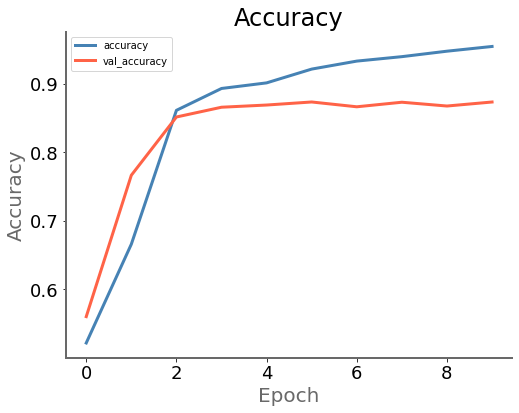

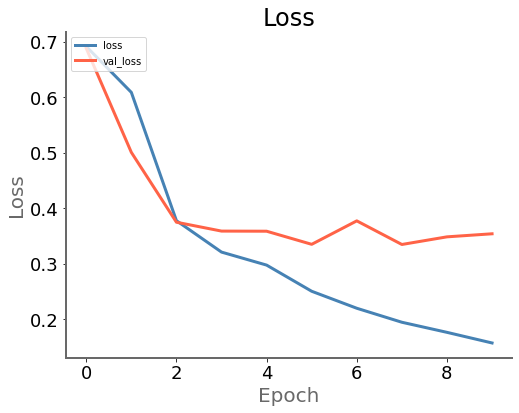

In [13]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.3347
x_test / accuracy  : 0.8728


#### Accuracy donut is :

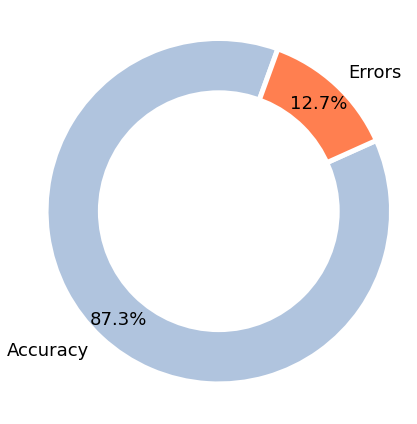

#### Confusion matrix is :

,0,1
0,0.89,0.11
1,0.14,0.86


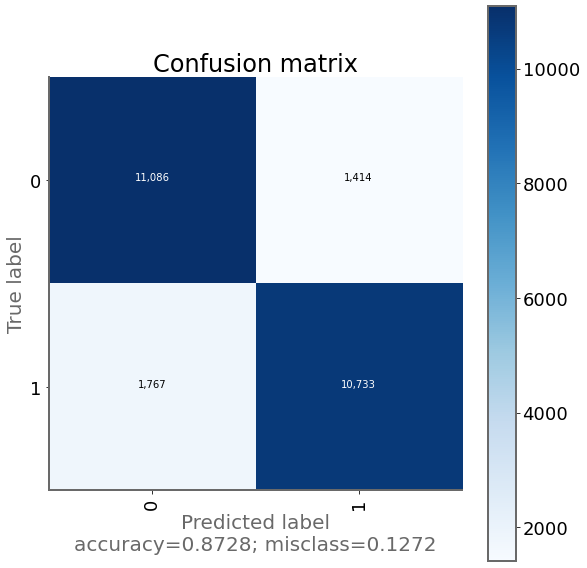

In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [15]:
pwk.end()

End time is : Monday 01 March 2021, 20:29:53
Duration is : 00:08:18 651ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>